In [111]:
import pandas as pd
import ast
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse, mse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelBinarizer, MinMaxScaler
pd.set_option('display.max_columns', 100)

In [3]:
dataset_dir = './datasets/The_Movies_Dataset/'

movie_df = pd.read_csv(dataset_dir + 'movies_metadata.csv')
movie_df.shape

C:\Users\cwy_i\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(45466, 24)

In [4]:
movie_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## Preprocessing

### Drop the unused columns and then drop NaN

In [5]:
movie_df_dropped = movie_df.drop(['homepage', 'overview', 'original_title', 'poster_path', 'tagline', 'belongs_to_collection', 'id', 'imdb_id'], axis=1)

In [6]:
movie_df_dropped = movie_df_dropped.dropna().reset_index().drop(['index'],axis=1)

### Tranform the column data to usable informarion

Transform the column data from list of objects to individual columns

In [7]:
movie_df_dropped['genres_name'] = movie_df_dropped['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
# movie_df_dropped['genres_id'] = movie_df_dropped['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['id'] for i in x] if isinstance(x, list) else [])
movie_df_dropped.drop(['genres'], axis=1, inplace=True)

movie_df_dropped['spoken_languages'] = movie_df_dropped['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['iso_639_1'] for i in x] if isinstance(x, list) else [])
movie_df_dropped['production_countries'] = movie_df_dropped['production_countries'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['iso_3166_1'] for i in x] if isinstance(x, list) else [])
movie_df_dropped['release_date'] = movie_df_dropped['release_date'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d')-datetime(1970,1,1)).total_seconds())

# movie_df['collection_name'] = movie_df['belongs_to_collection'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
# movie_df['collection_id'] = movie_df['belongs_to_collection'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['id'] for i in x] if isinstance(x, list) else [])
# movie_df.drop(['belongs_to_collection'], axis=1, inplace=True)

# movie_df_dropped['production_companies'] = movie_df_dropped['production_companies'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
# movie_df_dropped['production_companies'] = movie_df_dropped['production_companies'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['id'] for i in x] if isinstance(x, list) else [])

### Change the data types of quantitative data from string to float
The origin data types of budget and popularity are string.

In [8]:
# movie_df_dropped.describe(include=object)
movie_df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45043 entries, 0 to 45042
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45043 non-null  object 
 1   budget                45043 non-null  object 
 2   original_language     45043 non-null  object 
 3   popularity            45043 non-null  object 
 4   production_companies  45043 non-null  object 
 5   production_countries  45043 non-null  object 
 6   release_date          45043 non-null  float64
 7   revenue               45043 non-null  float64
 8   runtime               45043 non-null  float64
 9   spoken_languages      45043 non-null  object 
 10  status                45043 non-null  object 
 11  title                 45043 non-null  object 
 12  video                 45043 non-null  object 
 13  vote_average          45043 non-null  float64
 14  vote_count            45043 non-null  float64
 15  genres_name        

In [9]:
movie_df_dropped.budget = movie_df_dropped.budget.apply(float)
movie_df_dropped.popularity = movie_df_dropped.popularity.apply(float)

### Process categorical data

In [10]:
# cbe_encoder = ce.cat_boost.CatBoostEncoder()
# target = train[['grade']]
# cbe_encoder.fit(train, target)
# train_cbe = cbe_encoder.transform(train)
# ref: https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/

In [11]:
# movie_df.status.unique()
# movie_df[movie_df.status=='Released']

In [12]:
multi_label_genres = MultiLabelBinarizer()
genres_df = pd.DataFrame(multi_label_genres.fit_transform(movie_df_dropped.genres_name), columns=multi_label_genres.classes_)

multi_label_prod_countries = MultiLabelBinarizer()
prod_countries_df = pd.DataFrame(multi_label_prod_countries.fit_transform(movie_df_dropped.production_countries), columns=multi_label_prod_countries.classes_)
movie_df_dropped.production_countries = movie_df_dropped.production_countries.apply(len)

multi_label_lang = MultiLabelBinarizer()
spoken_languages_df = pd.DataFrame(multi_label_lang.fit_transform(movie_df_dropped.spoken_languages), columns=multi_label_lang.classes_)
movie_df_dropped.spoken_languages = movie_df_dropped.spoken_languages.apply(len)

label_status = LabelBinarizer()
status_df = pd.DataFrame(label_status.fit_transform(movie_df_dropped.status), columns=label_status.classes_)

one_hot = OneHotEncoder(drop='first')
adult_df = pd.DataFrame(one_hot.fit_transform(movie_df_dropped[['adult']]).toarray())

movie_df_encoded = pd.concat([movie_df_dropped, genres_df, prod_countries_df, spoken_languages_df, status_df], axis=1)
movie_df_encoded = movie_df_encoded.drop(['adult', 'genres_name', 'status'], axis=1)
movie_df_encoded['adult'] = adult_df
movie_df_encoded

,budget,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,video,vote_average,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,BA,BB,BD,BE,BF,...,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu,Canceled,In Production,Planned,Post Production,Released,Rumored,adult
0,30000000.0,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",1,8.150112e+08,373554033.0,81.0,1,Toy Story,False,7.7,5415.0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
1,65000000.0,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",1,8.189856e+08,262797249.0,104.0,2,Jumanji,False,6.9,2413.0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
2,0.0,en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1,8.195904e+08,0.0,101.0,1,Grumpier Old Men,False,6.5,92.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
3,16000000.0,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,1,8.195904e+08,81452156.0,127.0,1,Waiting to Exhale,False,6.1,34.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
4,0.0,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",1,7.923744e+08,76578911.0,106.0,1,Father of the Bride Part II,False,5.7,173.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45038,0.0,en,5.683753,"[{'name': 'Westdeutscher Rundfunk (WDR)', 'id'...",4,6.740928e+08,0.0,104.0,1,Robin Hood,False,5.7,26.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
45039,0.0,tl,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]",1,1.321488e+09,0.0,360.0,1,Century of Birthing,False,9.0,3.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
45040,0.0,en,0.903007,"[{'name': 'American World Pictures', 'id': 6165}]",1,1.059696e+09,0.0,90.0,1,Betrayal,False,3.8,6.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
45041,0.0,en,0.003503,"[{'name': 'Yermoliev', 'id': 88753}]",1,-1.647216e+09,0.0,87.0,0,Satan Triumphant,False,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0


### Remove outliers

In [78]:
# movie_df_encoded.boxplot(['budget'])
# sns.boxplot(x=movie_df_encoded.revenue)
# fig, ax = plt.subplots(figsize=(16,8))
# ax.scatter(movie_df_encoded['spoken_languages'], movie_df_encoded['popularity'])
# plt.show()

In [79]:
quantitative_cols = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count', 'release_date', 'production_countries', 'spoken_languages']
qualitative_predictors = multi_label_genres.classes_.tolist() + ['adult'] + label_status.classes_.tolist() + multi_label_prod_countries.classes_.tolist() + multi_label_lang.classes_.tolist()

z = np.abs(stats.zscore(movie_df_encoded[quantitative_cols]))
filtered_entries = (z < 3).all(axis=1)
df_removed_outliers = movie_df_encoded[filtered_entries]
df_removed_outliers.reset_index(inplace=True, drop=True)
df_removed_outliers.head()

# df_removed_outliers.boxplot(['budget'])
# sns.boxplot(x=df_removed_outliers.revenue)
# fig, ax = plt.subplots(figsize=(16,8))
# ax.scatter(df_removed_outliers['spoken_languages'], df_removed_outliers['popularity'])
# plt.show()

,budget,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,video,vote_average,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,BA,BB,BD,BE,BF,...,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu,Canceled,In Production,Planned,Post Production,Released,Rumored,adult
0,0.0,en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",1,819590400.0,0.0,101.0,1,Grumpier Old Men,False,6.5,92.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
1,16000000.0,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,1,819590400.0,81452156.0,127.0,1,Waiting to Exhale,False,6.1,34.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
2,0.0,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",1,792374400.0,76578911.0,106.0,1,Father of the Bride Part II,False,5.7,173.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
3,0.0,en,2.561161,"[{'name': 'Walt Disney Pictures', 'id': 2}]",1,819590400.0,0.0,97.0,2,Tom and Huck,False,5.4,45.0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0
4,35000000.0,en,5.231580,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",1,819590400.0,64350171.0,106.0,1,Sudden Death,False,5.5,174.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0


### Normalization

In [80]:
df_removed_outliers.describe()

,budget,popularity,production_countries,release_date,revenue,runtime,spoken_languages,vote_average,vote_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,BA,BB,BD,BE,BF,BG,BM,BN,BO,...,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu,Canceled,In Production,Planned,Post Production,Released,Rumored,adult
count,4.173900e+04,41739.000000,41739.000000,4.173900e+04,4.173900e+04,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,...,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.00000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000
mean,1.847630e+06,2.461133,1.024941,7.051723e+08,3.554168e+06,91.996478,1.106375,5.588943,50.071779,0.138048,0.067036,0.040202,0.293682,0.094372,0.087185,0.447040,0.058099,0.045737,0.036800,0.027720,0.107190,0.036393,0.053882,0.150004,0.063705,0.017633,0.166152,0.026762,0.023671,0.000359,0.000144,0.000072,0.000144,0.0,0.000072,0.0,0.005175,0.003714,0.011668,0.000120,0.000048,0.000551,0.000024,0.000048,0.008409,0.000096,0.001030,0.000024,0.000024,0.000192,...,0.011524,0.000144,0.002444,0.030403,0.000072,0.000024,0.000024,0.000072,0.0,0.000216,0.000048,0.000479,0.000431,0.000024,0.0,0.000096,0.000407,0.001821,0.000024,0.011380,0.000359,0.002444,0.001533,0.000024,0.002683,0.000024,0.001078,0.0,0.000024,0.004816,0.000048,0.000024,0.000024,0.000791,0.00091,0.000048,0.001102,0.000264,0.000192,0.004001,0.000839,0.015238,0.000264,0.000024,0.000407,0.000311,0.002276,0.991662,0.005319,0.000192
std,6.661075e+06,3.204795,0.606619,7.354111e+08,1.649063e+07,29.985737,0.575584,1.923134,141.049180,0.344955,0.250087,0.196436,0.455454,0.292349,0.282109,0.497193,0.233934,0.208916,0.188273,0.164171,0.309358,0.187268,0.225788,0.357079,0.244230,0.131616,0.372221,0.161388,0.152024,0.018954,0.011989,0.008478,0.011989,0.0,0.008478,0.0,0.071752,0.060826,0.107387,0.010944,0.006922,0.023468,0.004895,0.006922,0.091317,0.009789,0.032081,0.004895,0.004895,0.013843,...,0.106731,0.011989,0.049375,0.171696,0.008478,0.004895,0.004895,0.008478,0.0,0.014683,0.006922,0.021885,0.020762,0.004895,0.0,0.009789,0.020178,0.042633,0.004895,0.106071,0.018954,0.049375,0.039128,0.004895,0.051732,0.004895,0.032818,0.0,0.004895,0.069228,0.006922,0.004895,0.004895,0.028107,0.03016,0.006922,0.033180,0.016232,0.013843,0.063128,0.028946,0.122498,0.016232,0.004895,0.020178,0.017646,0.047654,0.090930,0.072737,0.013843
min,0.000000e+00,0.000000,0.000000,-1.573171e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

From the above 5-number summary, it is found that the scales vary between columns. Thus, we normalize the data to the same scale.

In [81]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_removed_outliers[quantitative_cols]), columns=quantitative_cols)
df_normalized = pd.concat([df_normalized, df_removed_outliers[qualitative_predictors]], axis=1)
df_normalized.describe()

,budget,revenue,popularity,runtime,vote_average,vote_count,release_date,production_countries,spoken_languages,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,adult,Canceled,In Production,Planned,Post Production,Released,Rumored,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,BA,BB,...,no,nv,ny,oc,pa,pl,ps,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
count,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,...,41739.000000,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.0,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.00000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000,41739.000000
mean,0.032993,0.017337,0.117739,0.440175,0.558894,0.031611,0.716179,0.341647,0.368792,0.138048,0.067036,0.040202,0.293682,0.094372,0.087185,0.447040,0.058099,0.045737,0.036800,0.027720,0.107190,0.036393,0.053882,0.150004,0.063705,0.017633,0.166152,0.026762,0.023671,0.000192,0.000024,0.000407,0.000311,0.002276,0.991662,0.005319,0.000359,0.000144,0.000072,0.000144,0.0,0.000072,0.0,0.005175,0.003714,0.011668,0.000120,0.000048,0.000551,0.000024,...,0.003163,0.000072,0.0,0.000096,0.000264,0.010470,0.000048,0.011524,0.000144,0.002444,0.030403,0.000072,0.000024,0.000024,0.000072,0.0,0.000216,0.000048,0.000479,0.000431,0.000024,0.0,0.000096,0.000407,0.001821,0.000024,0.011380,0.000359,0.002444,0.001533,0.000024,0.002683,0.000024,0.001078,0.0,0.000024,0.004816,0.000048,0.000024,0.000024,0.000791,0.00091,0.000048,0.001102,0.000264,0.000192,0.004001,0.000839,0.015238,0.000264
std,0.118948,0.080442,0.153315,0.143472,0.192313,0.089046,0.231171,0.202206,0.191861,0.344955,0.250087,0.196436,0.455454,0.292349,0.282109,0.497193,0.233934,0.208916,0.188273,0.164171,0.309358,0.187268,0.225788,0.357079,0.244230,0.131616,0.372221,0.161388,0.152024,0.013843,0.004895,0.020178,0.017646,0.047654,0.090930,0.072737,0.018954,0.011989,0.008478,0.011989,0.0,0.008478,0.0,0.071752,0.060826,0.107387,0.010944,0.006922,0.023468,0.004895,...,0.056148,0.008478,0.0,0.009789,0.016232,0.101786,0.006922,0.106731,0.011989,0.049375,0.171696,0.008478,0.004895,0.004895,0.008478,0.0,0.014683,0.006922,0.021885,0.020762,0.004895,0.0,0.009789,0.020178,0.042633,0.004895,0.106071,0.018954,0.049375,0.039128,0.004895,0.051732,0.004895,0.032818,0.0,0.004895,0.069228,0.006922,0.004895,0.004895,0.028107,0.03016,0.006922,0.033180,0.016232,0.013843,0.063128,0.028946,0.122498,0.016232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,

### Test for multicollinearity
This is the correlation map for quantitative predictors. It is found that the correlation coefficients of the columns are all less than 0.7, which are not significantly high.

In [82]:
# df_x = movie_df_merged[quantitative_predictors]

# quantitative_predictors = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'release_date', 'production_countries', 'spoken_languages']
# sns.pairplot(df_removed_outliers[quantitative_predictors])
# plt.show()

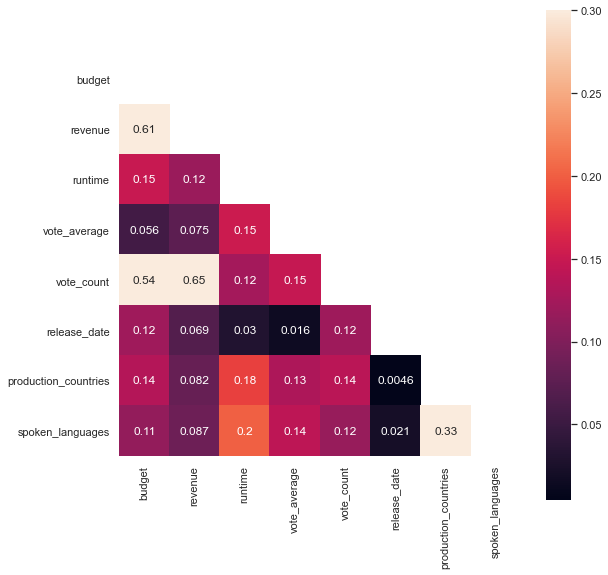

In [83]:
quantitative_predictors = ['budget', 'revenue', 'runtime', 'vote_average', 'vote_count', 'release_date', 'production_countries', 'spoken_languages']

sns.set(font_scale=1)
corr = df_normalized[quantitative_predictors].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

### Build Mulitple Linear Regression Model

In [90]:
y_rep = df_removed_outliers["popularity"].replace(0, 0.00000001)
y_trans = y_rep*y_rep

-18.420680743952367

In [120]:
quantitative_predictors = ['budget', 'revenue', 'vote_average', 'runtime', 'vote_count', 'release_date', 'production_countries', 'spoken_languages']
x = df_normalized[quantitative_predictors+qualitative_predictors]
# x['vote_average_2'] = df_normalized['vote_average']*df_normalized['vote_average']
y = df_removed_outliers["popularity"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

model = sm.OLS(y_train,sm.add_constant(x_train)).fit()
print('Adjusted r-square of train data: {:.4f}'.format(model.rsquared_adj))

y_pred = model.predict(sm.add_constant(x_test))
r2= r2_score(y_test, y_pred)
r2_adj = adj = 1 - float(len(y_test)-1)/(len(y_test)-len(model.params)-1)*(1 - r2)
print('Adjusted r-square of test data: {:.4f}'.format(r2_adj))

rmse_ = rmse(y_test, y_pred)
print('RMSE of test data: {:.4f}'.format(rmse_))

Adjusted r-square of train data: 0.5221
Adjusted r-square of test data: 0.5067
RMSE of test data: 2.2374


In [115]:
# fig,ax=plt.subplots()
# ax.axhline(linestyle="dashed")
# ax.scatter(model.fittedvalues, model.resid)

# plt.xlabel("Predicted values")
# plt.ylabel("Residuals")
# plt.title("Residual plot")
# plt.show()

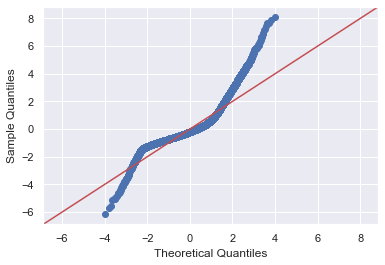

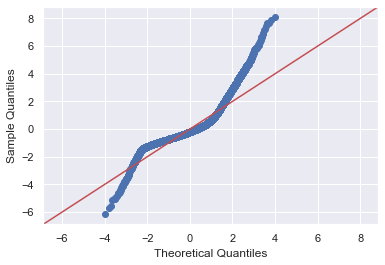

In [121]:
sm.qqplot(model.resid, fit=True, line="45")

Violate normality assumption, transform y

In [125]:
y = np.sqrt(df_removed_outliers["popularity"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

model_2 = sm.OLS(y_train,sm.add_constant(x_train)).fit()
print('Adjusted r-square of train data: {:.4f}'.format(model_2.rsquared_adj))

y_pred = model_2.predict(sm.add_constant(x_test))
r2= r2_score(y_test, y_pred)
r2_adj = adj = 1 - float(len(y_test)-1)/(len(y_test)-len(model_2.params)-1)*(1 - r2)
print('Adjusted r-square of test data: {:.4f}'.format(r2_adj))

rmse_ = rmse(y_test, y_pred)
mse_ = mse(y_test, y_pred)
print('RMSE of test data: {:.4f}'.format(rmse_))
print('MSE of test data: {:.4f}'.format(mse_))

Adjusted r-square of train data: 0.5426
Adjusted r-square of test data: 0.5210
RMSE of test data: 0.6202
MSE of test data: 0.3846


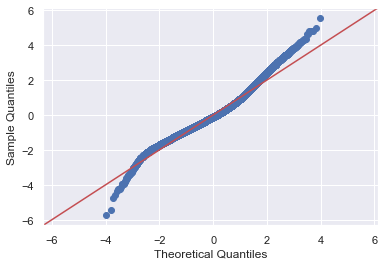

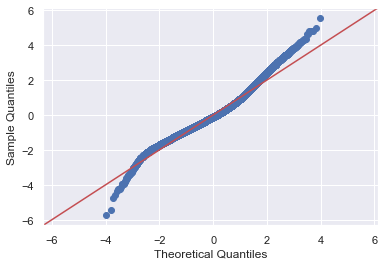

In [124]:
sm.qqplot(model_2.resid, fit=True, line="45")

In [118]:
# model = sm.OLS(y_train,sm.add_constant(x_train)).fit()
# print('Adjusted r-square of train data: {:.4f}'.format(model.rsquared_adj))

# y_pred = model.predict(sm.add_constant(x_test))
# r2= r2_score(y_test, y_pred)
# r2_adj = adj = 1 - float(len(y_test)-1)/(len(y_test)-len(model.params)-1)*(1 - r2)
# print('Adjusted r-square of test data: {:.4f}'.format(r2_adj))

# rmse_ = rmse(y_test, y_pred)
# print('RMSE of test data: {:.4f}'.format(rmse_))

In [161]:
# fig,ax=plt.subplots()
# ax.scatter(model_2.fittedvalues, y_train)
# plt.xlabel("Predicted values")
# plt.ylabel("y")
# # plt.title("Residual plot")
# plt.show()

### Conduct feature selection to reduce dimension and multicollinearity

In [24]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=50,
          forward=True,
          floating=True,
          scoring = 'r2',
          cv = 3)

sfs.fit(x_train, y_train)
sfs.k_feature_names_     # to get the final set of features

('budget',
 'vote_average',
 'runtime',
 'vote_count',
 'release_date',
 'production_countries',
 'spoken_languages',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'Western',
 'Rumored',
 'AU',
 'CA',
 'CN',
 'DE',
 'DK',
 'ES',
 'FR',
 'GB',
 'HK',
 'IE',
 'IN',
 'IT',
 'JP',
 'NZ',
 'PH',
 'US',
 'ZA',
 'en',
 'fr',
 'hu',
 'it',
 'la',
 'ml',
 'pt',
 'ta')

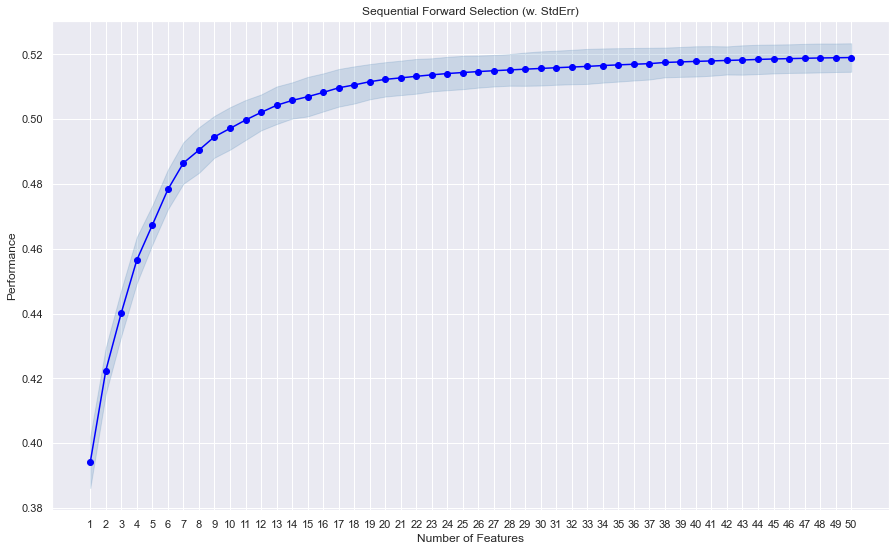

In [164]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(15,9))
plt.title('Sequential Forward Selection (w. StdErr)')
plt.show()

R-squared of full model can be achived by 50-dimension model. After reducing the dimension, we generate polynomial features for better performance.

In [137]:
selected_features = list(sfs.k_feature_names_)

In [158]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special

x_selected = x[selected_features]
poly = PolynomialFeatures()
X_tr = poly.fit_transform(x_selected)

x_train_selected, x_test_selected, y_train_selected, y_test_selected = train_test_split(X_tr, y, test_size=0.3, random_state=0)

In [159]:
pd.DataFrame(X_tr,columns=poly.get_feature_names())

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,...,x40 x45,x40 x46,x40 x47,x40 x48,x40 x49,x41^2,x41 x42,x41 x43,x41 x44,x41 x45,x41 x46,x41 x47,x41 x48,x41 x49,x42^2,x42 x43,x42 x44,x42 x45,x42 x46,x42 x47,x42 x48,x42 x49,x43^2,x43 x44,x43 x45,x43 x46,x43 x47,x43 x48,x43 x49,x44^2,x44 x45,x44 x46,x44 x47,x44 x48,x44 x49,x45^2,x45 x46,x45 x47,x45 x48,x45 x49,x46^2,x46 x47,x46 x48,x46 x49,x47^2,x47 x48,x47 x49,x48^2,x48 x49,x49^2
0,1.0,0.000000,0.65,0.483254,0.058081,0.752146,0.333333,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.285714,0.61,0.607656,0.021465,0.752146,0.333333,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.000000,0.57,0.507177,0.109217,0.743590,0.333333,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.000000,0.54,0.464115,0.028409,0.752146,0.333333,0.666667,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.625000,0.55,0.507177,0.109848,0.752146,0.333333,0.333333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41734,1.0,0.000000,0.70,0.215311,0.001263,0.800109,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41735,1.0,0.000000,0.70,0.143541,0.000631,0.799593,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [160]:
model_3 = sm.OLS(y_train,x_train_selected).fit()
print('Adjusted r-square of train data: {:.4f}'.format(model_3.rsquared_adj))

y_pred = model_3.predict(x_test_selected)
r2= r2_score(y_test, y_pred)
r2_adj = adj = 1 - float(len(y_test)-1)/(len(y_test)-len(model_3.params)-1)*(1 - r2)
print('Adjusted r-square of test data: {:.4f}'.format(r2_adj))

rmse_ = rmse(y_test, y_pred)
mse_ = mse(y_test, y_pred)
print('RMSE of test data: {:.4f}'.format(rmse_))
print('MSE of test data: {:.4f}'.format(mse_))

Adjusted r-square of train data: 0.6616
Adjusted r-square of test data: 0.5887
RMSE of test data: 0.5508
MSE of test data: 0.3033


The new model has higher r-square and smaller MSE.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(x_train)

x_pca = pca.transform(x_train)
print("original shape:   ", x_train.shape)
print("transformed shape:", x_pca.shape)

model = sm.OLS(y_train,sm.add_constant(x_pca)).fit()
print('Adjusted r-square of test data: {:.4f}'.format(model.rsquared_adj))

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special
poly = PolynomialFeatures(interaction_only=True)
X_tr = poly.fit_transform(x)
# pd.DataFrame(X_tr,columns=poly.get_feature_names())

In [ ]:
# pca_2 = PCA(n_components=1000)
# pca_2.fit(X_tr)

# x_pca_2 = pca_2.transform(X_tr)
# print("original shape:   ", X_tr.shape)
# print("transformed shape:", x_pca_2.shape)

In [ ]:
model = sm.OLS(y_train,sm.add_constant(X_tr)).fit()
print('Adjusted r-square of test data: {:.4f}'.format(model.rsquared_adj))

In [ ]:
# Xt = pd.concat([Xb,pd.DataFrame(X_tr,columns=poly.get_feature_names()).drop(['1','x0','x1','x2','x3','x4'],1)],1)
# mod = sm.OLS(y_train, X_tr)
# res = mod.fit()
# res.summary()

In [2]:
sm.qqplot(model.resid, fit=True, line="45")

NameError: name 'sm' is not defined

In [3]:
# fig,ax=plt.subplots()
# ax.axhline(linestyle="dashed")
# ax.scatter(res.fittedvalues, res.resid)

# plt.xlabel("Predicted values")
# plt.ylabel("Residuals")
# plt.title("Residual plot")
# plt.show()

In [4]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(x_pca_2,y_train)
# clf.predict(x_test)
clf.score(x_pca_2,y_train)

NameError: name 'x_pca_2' is not defined

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(),
          k_features=50,
          forward=True,
          floating=True,
          scoring = 'r2',
          cv = 3)

sfs.fit(x_train, y_train)
sfs.k_feature_names_     # to get the final set of features

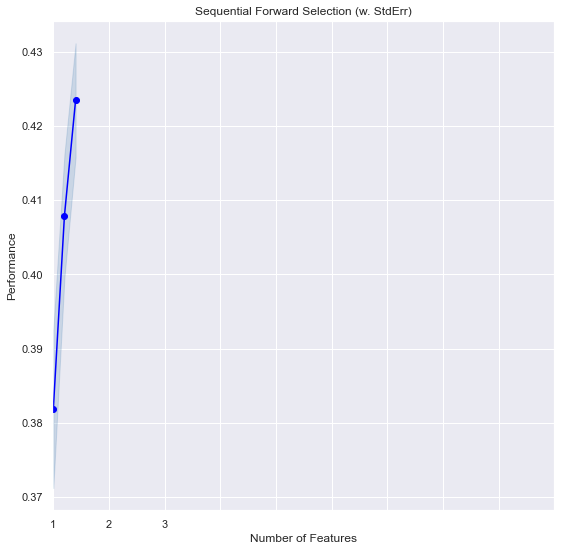

In [1056]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(9,9))
plt.title('Sequential Forward Selection (w. StdErr)')
plt.xticks(np.arange(1, 51, 5))
plt.show()

In [938]:
# x = sm.add_constant(df_normalized[quantitative_predictors+qualitative_predictors])
# y = df_normalized["popularity"]
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
# model_2 = sm.OLS(y_train,x_train).fit()
# print('Adjusted r-square of train data: ', model_2.rsquared_adj)

In [939]:
# y_pred = model_2.predict(x_test)
# r2= r2_score(y_test, y_pred)
# r2_adj = adj = 1 - float(len(y_test)-1)/(len(y_test)-len(model_2.params)-1)*(1 - r2)
# print('Adjusted r-square of test data: ', r2_adj)

From the correlation matrix, it is observed that a large amount of data in budget and revenue columns are zero which is not reasonable. We try to remove the entries with 0 budget or 0 revenue and fit the model. However, only 3850 rows left and the adjusted R squared dropped.

In [940]:
# movie_df_2 = df_removed_outliers.copy()
# movie_df_2.budget = movie_df_2.budget.replace(0, np.nan)
# movie_df_2.revenue=movie_df_2.revenue.replace(0, np.nan)
# movie_df_2.dropna(inplace=True)
# movie_df_2.info()

In [941]:
# x_2 = sm.add_constant(movie_df_2[quantitative_predictors+qualitative_predictors])
# model_2 = sm.OLS(movie_df_2["popularity"],x_2.astype(float)).fit()
# model_2.rsquared_adj

In [942]:
# x_3_col = ['runtime', 'vote_average', 'vote_count', 'release_date', 'production_countries', 'spoken_languages']
# x_3 = sm.add_constant(df_removed_outliers[x_3_col+qualitative_predictors])
# model_3 = sm.OLS(df_removed_outliers["popularity"],x_3.astype(float)).fit()
# model_3.rsquared_adj